In [4]:
from DataProcessing import LUNA
%matplotlib inline

import dicom as dc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import xml
from xml.etree import ElementTree
from shapely.geometry import Polygon
from shapely.geometry import Point

luna = LUNA()

Training Data found: 1203
Evaluation Data found: 1203
XML Training Data found: 14
XML Evaluation Data found: 14


In [48]:
from random import randint
import util as ut
j = 0
path = ''
xml_path = ''
path_list = []
z_position = 0
annotations = np.zeros(shape=(512,512))
nodules = np.zeros(shape=(512,512))
while j<1000:
    xml_path = luna.xml_training_list[randint(0, luna.xml_training_list_length-1)]
    if luna.valid_xml(xml_path):
        f = ElementTree.parse(xml_path).getroot()
        docs = f.findall('{http://www.nih.gov}readingSession')
        nodules = docs[randint(0, len(docs)-1)].findall('{http://www.nih.gov}unblindedReadNodule')
        nod = nodules[randint(0,len(nodules)-1)]
        slices= nod.findall('{http://www.nih.gov}roi')
        slice = slices[randint(0,len(slices)-1)]
        z_position = float(slice[0].text)
        id = slice[1].text
        if len(slice.findall('{http://www.nih.gov}edgeMap')) > 10:
            # read out annotation map of chosen nodule
            annotations = np.zeros(shape=(512,512))
            nodules = np.zeros(shape=(512,512))
            vertices = []
            for coord in slice.findall('{http://www.nih.gov}edgeMap'):
                vertices.append((int(coord[0].text), int(coord[1].text)))
                annotations[int(coord[0].text), int(coord[1].text)] = 1
                nodules[int(coord[0].text), int(coord[1].text)] = 1
            try:
                poly = Polygon(vertices)
                bnd = poly.bounds
                for x in range(int(bnd[0]), int(bnd[2] + 1)):
                    for y in range(int(bnd[1]), int(bnd[3] + 1)):
                        point = Point(x, y)
                        if point.within(poly):
                            nodules[x, y] = 1
                j = 1000
            except ValueError:
                nodules = annotations
                print('Polygone filling failed. Draw new nodule')
    j = j+1
    
k = -1
while (not xml_path[k] == '/') and k > -1000:
    k = k - 1
last_number = len(xml_path) + k
cut_path = xml_path[0:last_number]
path_list = ut.find('*dcm', cut_path)

### find image in path_list that fits the z position and id of the chosen nodule
for im_path in path_list:
    dc_file = dc.read_file(im_path)
    image_z = (dc_file[0x0020, 0x0032].value)[2]
    image_id = dc_file[0x0008, 0x0018].value
    if image_z == z_position:
        path = im_path
        assert image_id == id

dc_file = dc.read_file(path)
pic = dc_file.pixel_array
pic = pic - np.amin(pic)
pic = pic / np.amax(pic)

Ids match!


In [49]:
print(vertices)
print(annotations[141,319])
print(nodules[141,319])
print(np.average(annotations))
print(np.average(nodules))

[(392, 338), (393, 337), (394, 336), (395, 335), (396, 334), (396, 333), (396, 332), (396, 331), (395, 330), (394, 329), (393, 328), (392, 328), (391, 328), (390, 329), (389, 330), (389, 331), (389, 332), (388, 333), (387, 334), (387, 335), (387, 336), (388, 337), (389, 338), (390, 338), (391, 338), (392, 338)]
0.0
0.0
9.53674316406e-05
0.000293731689453


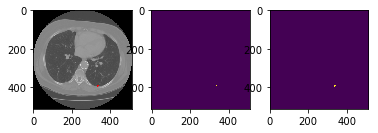

In [8]:
#path, xml_path = luna.get_random_path(training_data=True)
# pic, anno, nod = luna.get_raw_data(path, xml_path)
pic, nodules, anno = luna.load_nodule()

size = pic.shape
three_c = np.zeros(shape=[size[0], size[1], 3])
for k in range(3):
    three_c[...,k] = pic
    
# set red chanel to 1 whenever in nodules and set all other channels to 0
for x in range(size[0]):
    for y in range(size[1]):
        if nodules[x,y]==1:
            three_c[x,y,0] = 1
            three_c[x,y,1] = 0
            three_c[x,y,2] = 0
    
plt.figure()
plt.subplot(131)
plt.imshow(three_c)
plt.subplot(132)
plt.imshow(anno)
plt.subplot(133)
plt.imshow(nodules)
plt.show()

In [1]:
import tensorflow as tf
from Networks import UNet_segmentation
sess = tf.InteractiveSession()

net = UNet_segmentation( size = (512,512), colors=1)

input_image = tf.placeholder(shape=(None, 512, 512, 1), dtype=tf.float32)
input_seg = tf.placeholder(shape=(None, 512, 512, 1), dtype=tf.float32)

output_seg = net.net(input_image)

In [2]:
loss1 = - tf.reduce_mean(tf.multiply(tf.log(output_seg), input_seg))
loss2 = - tf.reduce_mean(tf.multiply(tf.log(1-output_seg), 1-input_seg))
loss  = 100*loss1 + loss2